# Polish wiki language model

### MultiFiT configuration (architecture by Pierre Guillou - 4 QRNN with 1550 hidden parameters by layer / tokenizer SentencePiece)

**Note**: The training times shown in the tables on this page are the sum of the creation time of Fastai Databunch and the training duration of the bidirectional model over 10 periods. The download time of the Wikipedia corpus and its preparation time are not counted.

**Training note** Model trained using the **Tesla V100**. The training time of one epoch on this processor should not last longer than 1 hour. If you train the model for your language and the training time is longer, try reducing the learning rate by 5-10x.

## Initialisation

In [1]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# batch size to be choosen according to your GPU 
# bs=48
# bs=24
bs=50

In [3]:
torch.cuda.set_device(0)

In [4]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.61
cuda: True


In [5]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.6
fastai        : 1.0.61
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.87
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.9.0-12-amd64-x86_64-with-debian-9.12
distro        : #1 SMP Debian 4.9.210-1 (2020-01-20)
conda env     : base
python        : /opt/conda/bin/python
sys.path      : /home/maciejbrasewicz/language-models
/opt/conda/lib/python37.zip
/opt/conda/lib/python3.7
/opt/conda/lib/python3.7/lib-dynload
/opt/conda/lib/python3.7/site-packages
/opt/conda/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-r

In [6]:
data_path = Config.data_path()

In [7]:
lang = 'pl'

In [8]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

lm_fns3 = [f'{lang}_wt_sp15_multifit', f'{lang}_wt_vocab_sp15_multifit']
lm_fns3_bwd = [f'{lang}_wt_sp15_multifit_bwd', f'{lang}_wt_vocab_sp15_multifit_bwd']

## Data (Polish wikipedia)

### Download data

In [9]:
from nlputils import split_wiki,get_wiki
from nlputils2 import *

In [11]:
%%time
get_wiki(path,lang)

downloading...


unzipping...
extracting...
CPU times: user 5min 45s, sys: 9.8 s, total: 5min 55s
Wall time: 21min 15s


In [10]:
ls /home/opt/site-packages/fastai/text/data.py

ls: cannot access '/home/opt/site-packages/fastai/text/data.py': No such file or directory


In [22]:
%%time
split_wiki(path,lang)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
CPU times: user 15.3 s, sys: 5.84 s, total: 21.1 s
Wall time: 21.5 s


PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/docs')

In [23]:
path.ls()

[PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/log'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/plwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/docs'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/wikiextractor'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/plwiki-latest-pages-articles.xml'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/plwiki')]

In [24]:
!head -n4 {path}/{name}

<doc id="2" url="https://pl.wikipedia.org/wiki?curid=2" title="AWK">
AWK

AWK – interpretowany język programowania, którego główną funkcją jest wyszukiwanie i przetwarzanie wzorców w plikach lub strumieniach danych. Jest także nazwą programu początkowo dostępnego dla systemów operacyjnych będących pochodnymi UNIX-a, obecnie także na inne platformy.


In [11]:
# %%time
folder = "docs"
clean_files(path,folder)

IndexError: list index out of range

In [12]:
dest = path/'docs'
dest.ls()[:5]

[PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/docs/Kość prącia.txt'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/docs/Profim.txt'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/docs/Zirydzi.txt'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/docs/Blood on the Tracks.txt'),
 PosixPath('/home/maciejbrasewicz/.fastai/data/plwiki/docs/Pałac Mieroszewskich.txt')]

In [43]:
!head -n4 {dest}/'Kość prącia.txt'

Kość prącia ("os penis"), bakulum ("baculum") – heterotopowa kość występująca w prąciu u większości mięsożernych, owadożernych, nietoperzy i niektórych naczelnych. Generalnie nie występuje u człowieka, wyraków i niektórych szerokonosych, natomiast są znane bardzo nieliczne przypadki ludzi, u których najprawdopodobniej doszło do skostnienia tkanki łącznej i wytworzyła się kość prącia. Kość usztywnia narząd podczas kopulacji, a jej rozmiar waha się w zależności od gatunku. Jej charakterystyka może posłużyć do rozróżniania gatunków zwierząt morfologicznie podobnych do siebie. W przypadku gatunków nieposiadających kości prącia jego sztywność podczas kopulacji osiągana jest dzięki zwiększeniu ciśnienia krwi w ciałach jamistych. Narządem homologicznym do kości prącia u samic ssaków jest kość łechtaczki (łac. "os clitoridis").

Ludzie w przeciwieństwie do wielu innych naczelnych nie posiadają kości prącia i kości łechtaczki. U innych człowiekowatych także występuje kość prącia, ale jest wzglę

### Size of downloaded data in the docs folder

In [28]:
%%time
num_files, num_tokens = get_num_tokens(dest)
print(f'{num_files} files - {num_tokens} tokens')

219076 files - 136443716 tokens
CPU times: user 18.4 s, sys: 3.42 s, total: 21.8 s
Wall time: 1min 44s


### Create a corpus of about 100 millions of tokens

In [29]:
%%time
path_corpus = get_corpus(dest, path, num_tokens, obj_tokens=1e8)

files copied to the new corpus folder: /home/maciejbrasewicz/.fastai/data/plwiki/corpus_100000000
CPU times: user 9.24 s, sys: 7.3 s, total: 16.5 s
Wall time: 25.1 s


In [30]:
%%time
# VERIFICATION of the number of words in the corpus folder
num_files_corpus, num_tokens_corpus = get_num_tokens(path_corpus)
print(f'{num_files_corpus} files - {num_tokens_corpus} tokens')

207422 files - 100217189 tokens
CPU times: user 14.4 s, sys: 2.49 s, total: 16.9 s
Wall time: 1min 35s


In [31]:
# change name of the corpus 
!mv {path}/'corpus_100000000' {path}/'corpus2_100'

## Databunch

In [14]:
dest = path/'corpus2_100'

### Forward

In [15]:
%%time
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(bs=bs, num_workers=1))

CPU times: user 59min 28s, sys: 22.7 s, total: 59min 51s
Wall time: 21min 44s


In [16]:
data.save(f'{path}/{lang}_databunch_corpus2_100_sp15_multifit')

In [17]:
len(data.vocab.itos),len(data.train_ds)

(15000, 186672)

In [18]:
len(data.vocab.itos),len(data.vocab.stoi)

(15000, 15000)

In [19]:
data.train_ds.x[1]

Text [    2     5  1731   687 ...  3305    45 13449    11]

### Backward

In [ ]:
%%time
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()
            .databunch(bs=bs, num_workers=1, backwards=True))

data.save(f'{path}/{lang}_databunch_corpus2_100_sp15_multifit_bwd')

# Training

### Forward

In [20]:
%%time
data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit', bs=bs)

CPU times: user 4.27 s, sys: 524 ms, total: 4.8 s
Wall time: 4.8 s


In [21]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [22]:
%%time
perplexity = Perplexity()
learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=0., pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 3.32 s, sys: 1.24 s, total: 4.56 s
Wall time: 51.7 s


In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


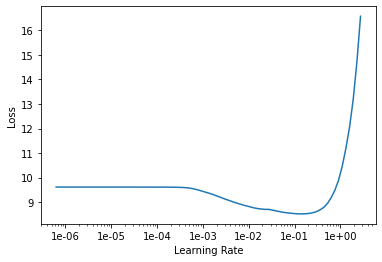

In [24]:
learn.recorder.plot()

In [25]:
lr = 2e-3
lr *= bs/48  # Scale learning rate by batch size

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.748520,3.795424,0.664157,0.335843,44.497341,53:18
1,3.340260,3.446060,0.629742,0.370260,31.376614,53:20
2,3.291498,3.340959,0.618337,0.381662,28.246082,53:19
3,3.146462,3.248430,0.607005,0.392993,25.749987,53:18
4,3.092724,3.168828,0.596344,0.403656,23.779572,53:19
5,2.955182,3.087852,0.585469,0.414531,21.929880,53:20
6,2.924353,3.005777,0.573463,0.426537,20.201838,53:19
7,2.911258,2.928103,0.561421,0.438578,18.692120,53:18
8,2.796234,2.871693,0.551848,0.448152,17.666939,53:20
9,2.758184,2.857777,0.549096,0.450904,17.422834,53:18


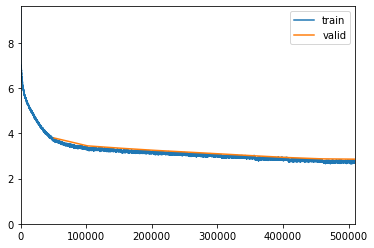

Better model found at epoch 0 with accuracy value: 0.33584296703338623.
Better model found at epoch 1 with accuracy value: 0.37025967240333557.
Better model found at epoch 2 with accuracy value: 0.38166236877441406.
Better model found at epoch 3 with accuracy value: 0.39299267530441284.
Better model found at epoch 4 with accuracy value: 0.4036560356616974.
Better model found at epoch 5 with accuracy value: 0.4145313799381256.
Better model found at epoch 6 with accuracy value: 0.42653703689575195.
Better model found at epoch 7 with accuracy value: 0.4385780096054077.
Better model found at epoch 8 with accuracy value: 0.4481520354747772.
Better model found at epoch 9 with accuracy value: 0.45090386271476746.
CPU times: user 6h 38min 39s, sys: 2h 16min 36s, total: 8h 55min 15s
Wall time: 8h 53min 54s


In [26]:
%%time
learn.unfreeze()
wd = 0.01 
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[ShowGraph(learn),
                               SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='bestmodel_sp15_multifit')])

In [27]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns3[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns3[1] + '.pkl'))

In [44]:
ls /home/maciejbrasewicz/.fastai/data/plwiki/models

bestmodel_sp15_multifit.pth  pl_wt_vocab_sp15_multifit.pkl
pl_wt_sp15_multifit.pth      tmp.pth
